<a href="https://colab.research.google.com/github/ns-0437/Weather-Prediction/blob/main/WeatherForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


Load the Dataset

In [2]:
# Read the dataset directly from the given file path
file_path = '/content/weatherHistory.csv'
data = pd.read_csv(file_path)

# Display dataset info
print("Dataset Shape:", data.shape)
data.head()


Dataset Shape: (18461, 12)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


### Data Preprocessing


In [3]:
# Drop irrelevant columns
data = data.drop(['Formatted Date', 'Summary', 'Daily Summary'], axis=1)

# Handle missing values in 'Precip Type'
data['Precip Type'] = data['Precip Type'].fillna('none')

# One-hot encode 'Precip Type'
data = pd.get_dummies(data, columns=['Precip Type'])

# Normalize numerical features
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Check the shape of the normalized data
print("Normalized Data Shape:", normalized_data.shape)


Normalized Data Shape: (18461, 11)


### Feature Engineering

In [4]:
# Function to create sequences for multi-output regression
def create_sequences(data, seq_length=5, output_indices=[2, 3, 5, 8, 10]):
    """
    Args:
        data: Normalized dataset (numpy array)
        seq_length: Number of previous days to use as input
        output_indices: Column indices for the target variables
    Returns:
        X: Input features (past `seq_length` days)
        y: Target features (selected columns for next day)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])  # Past `seq_length` days
        y.append(data[i+seq_length, output_indices])  # Next day's selected parameters
    return np.array(X), np.array(y)

# Specify the indices of the columns you want to predict
# Indices correspond to the normalized dataset columns: [Temperature (C), Humidity, Wind Speed, Visibility, Pressure]
output_columns = [2, 3, 5, 8, 10]
X, y = create_sequences(normalized_data, seq_length=5, output_indices=output_columns)

# Check shapes of the inputs and outputs
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)  # y should have 5 columns


Shape of X: (18456, 5, 11)
Shape of y: (18456, 5)


### Split the data

In [5]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the shapes of the splits
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (14764, 5, 11)
X_test Shape: (3692, 5, 11)
y_train Shape: (14764, 5)
y_test Shape: (3692, 5)


### Build LSTM Model

In [6]:
# Define the model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(5)  # Output layer for 5 target parameters
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 64)               │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,037 (125.14 KB)

 Trainable params: 32,037 (125.14 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

Epoch 1/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0439 - val_loss: nan
Epoch 2/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0108 - val_loss: nan
Epoch 3/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0090 - val_loss: nan
Epoch 4/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0091 - val_loss: nan
Epoch 5/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0085 - val_loss: nan
Epoch 6/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0089 - val_loss: nan
Epoch 7/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0089 - val_loss: nan
Epoch 8/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0084 - val_loss: nan
Epoch 9/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0087 - val_loss: nan
Epoch 10/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0089 - val_loss: nan
Epoch 11/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0091 - val_loss: nan
Epoch 12/20
462/462 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0083 - val_loss: na

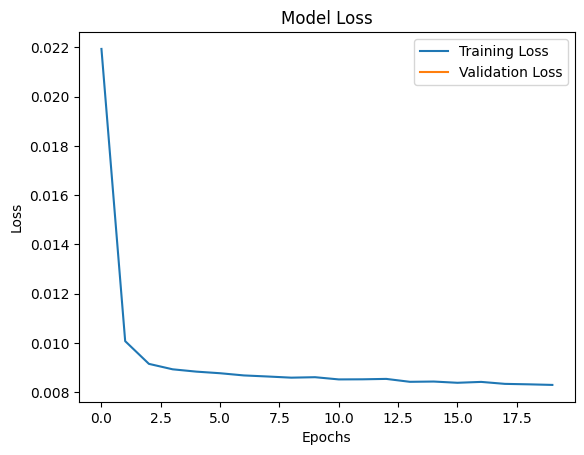

In [7]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


### Evaluating the model

In [8]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: nan   
Test Loss: nan


### Making Predictions

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


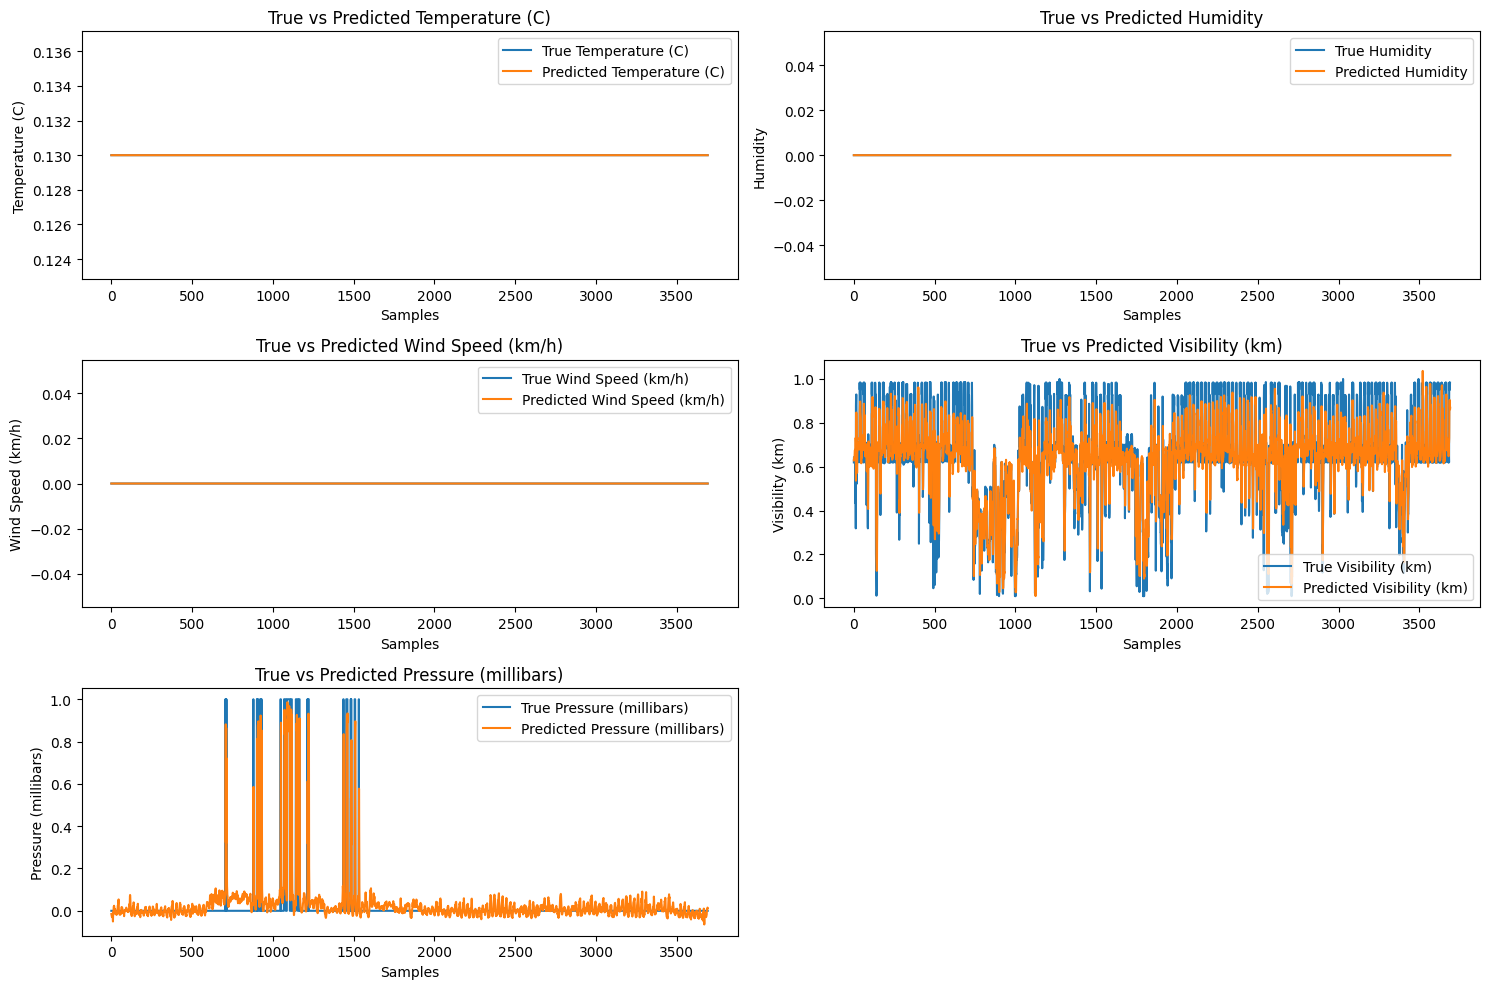

In [10]:
# Make predictions
predictions = model.predict(X_test)

# Convert predictions and true values back to their original scales
predicted_values = scaler.inverse_transform(
    np.hstack([np.zeros((predictions.shape[0], normalized_data.shape[1] - len(output_columns))), predictions])
)[:, [2, 3, 5, 8, 10]]

true_values = scaler.inverse_transform(
    np.hstack([np.zeros((y_test.shape[0], normalized_data.shape[1] - len(output_columns))), y_test])
)[:, [2, 3, 5, 8, 10]]

# Plot true vs predicted values for all five parameters
parameters = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']

plt.figure(figsize=(15, 10))
for i in range(len(parameters)):
    plt.subplot(3, 2, i + 1)
    plt.plot(true_values[:, i], label=f"True {parameters[i]}")
    plt.plot(predicted_values[:, i], label=f"Predicted {parameters[i]}")
    plt.title(f"True vs Predicted {parameters[i]}")
    plt.xlabel("Samples")
    plt.ylabel(parameters[i])
    plt.legend()

plt.tight_layout()
plt.show()


### Denormalize the Predictions

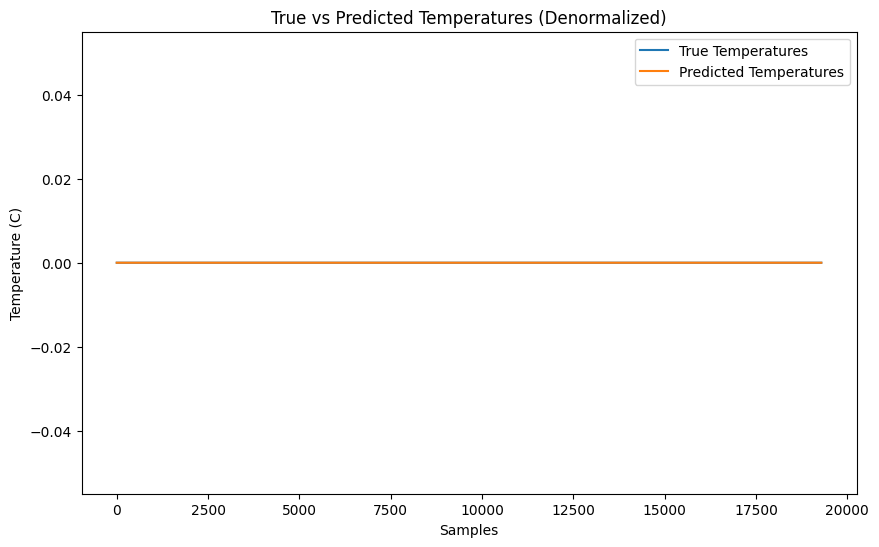

In [ ]:
# Reverse normalization for interpretation
predicted_temperatures = scaler.inverse_transform(
    np.hstack([np.zeros((predictions.shape[0], normalized_data.shape[1]-1)), predictions])
)[:, 2]

true_temperatures = scaler.inverse_transform(
    np.hstack([np.zeros((y_test.shape[0], normalized_data.shape[1]-1)), y_test.reshape(-1, 1)])
)[:, 2]

# Plot true vs predicted temperatures (denormalized)
plt.figure(figsize=(10, 6))
plt.plot(true_temperatures, label='True Temperatures')
plt.plot(predicted_temperatures, label='Predicted Temperatures')
plt.title("True vs Predicted Temperatures (Denormalized)")
plt.xlabel("Samples")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()
